In [112]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [113]:
# Load dataset
data = pd.read_csv('spam.csv',encoding='ISO-8859-1')

In [114]:
# Display first 5 rows
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# Data Cleaning

In [116]:
data=data[['v1','v2']].copy()

In [117]:
data.rename(columns={'v1':'class','v2':'text'},inplace=True)

In [118]:
data['target']=data['class'].map({'ham':0 ,'spam':1})

In [119]:
new_data=data[['target','text']]

In [120]:
# duplicate values
new_data.duplicated().sum()

403

In [121]:
new_data.drop_duplicates(inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_21808\3898862419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop_duplicates(inplace=True)


In [122]:
new_data.duplicated().sum()

0

In [123]:
new_data

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ï¿½_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


# Visualization

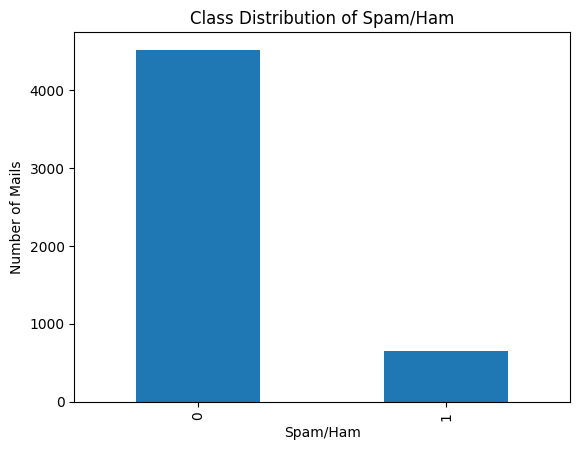

In [124]:
new_data['target'].value_counts().plot(kind='bar')
plt.title('Class Distribution of Spam/Ham')
plt.xlabel('Spam/Ham')
plt.ylabel('Number of Mails')
plt.show()

- 1 is spam 
- 0 is ham 
- data is imbalance

# Text Data Preprocessing
* Lower case
* Tokenization
* Remove special characters
* removing stop words and punctuaction
* stemming

In [125]:
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
import string

In [126]:
ps=PorterStemmer()

In [127]:
def transform_data(data):
    data = data.lower()
    data= nltk.word_tokenize(data)
    
    y=[]
    for i in data:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words("english") and i not in string.punctuation:
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
            
    return " ".join(y)

In [128]:
transform_data("hello guys I am naim!")

'hello guy naim'

In [129]:
new_data['transformed_txt']=new_data.text.apply(transform_data)

C:\Users\User\AppData\Local\Temp\ipykernel_21808\1073675367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['transformed_txt']=new_data.text.apply(transform_data)


In [130]:
spam_corpus = []
for msg in new_data[new_data['target']==1]['transformed_txt'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [131]:
len(spam_corpus)

9936

# Word Counter

In [132]:
from collections import Counter

In [136]:
import re

import nltk
from nltk.corpus import stopwords


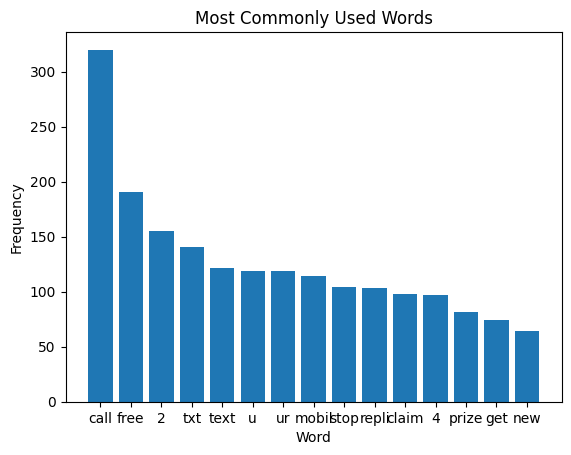

In [137]:
top_words = Counter(spam_corpus).most_common(15)
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

In [138]:
ham_corpus = []
for msg in new_data[new_data['target']==0]['transformed_txt'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [139]:
len(ham_corpus)

35305

# Model

In [140]:
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer()

In [141]:
new_data.reset_index(inplace=True)

In [142]:
X = cv.fit_transform(new_data['transformed_txt']).toarray()
y=new_data['target'].values

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix ,precision_score , recall_score
params={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
gs=GridSearchCV(log_clf,params,cv=3,verbose=3)
gs.fit(X_train,y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 3/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 1/3] END ...............C=0.001, penalty=l2;, score=0.877 total time=   0.1s
[CV 2/3] END ...............C=0.001, penalty=l2;, score=0.877 total time=   0.1s
[CV 3/3] END ...............C=0.001, penalty=l2;, score=0.877 total time=   0.1s
[CV 1/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 3/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 1/3] END ................C=0.01, penalty=l2;, score=0.885 total time=   0.1s
[CV 2/3] END ................C=0.01, penalty=l2;, score=0.890 total time=   0.1s
[CV 3/3] END ................C=0.01, penalty=l2;

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Lo

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [145]:
gs.best_score_

0.9794440626257502

In [146]:
gs.best_params_

{'C': 1000.0, 'penalty': 'l2'}

In [147]:
y_pred=gs.predict(X_test)


# Evaluation

In [148]:

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.99%
Recall: 88.97%


In [149]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[885,   4],
       [ 16, 129]], dtype=int64)

## Confusion matrix 

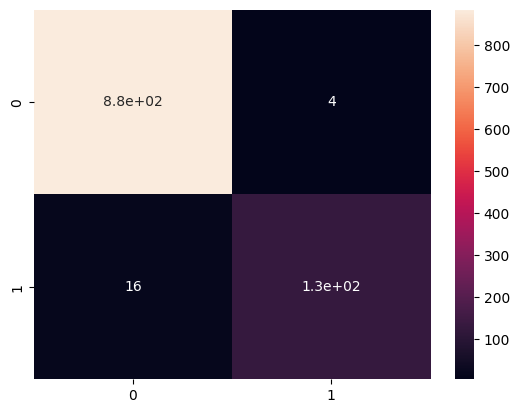

In [150]:

sns.heatmap(cm,annot=True)
plt.show()

In [151]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.97      0.89      0.93       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

